# Using k-means clustering to discover discrepancies between the two counter-circulating beams of the Large Hadron Collider

4 kinds of analysis (k-means clustering, Euclidean distance, DBSCAN, Linear classifier) x 2 kinds of data (PCA, not PCA) x 4 beam modes (flat_top, start_ramp, start_adjust, start_squeeze)

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.cluster import KMeans

## Load data


This data must be available before running this notebook.  Run the `Data collection.ipynb` notebook to create the data if it does not exist.

In [2]:
# Read saved ('pickled') DataFrames (result of Data collection notebook)
startRampLosses = pd.read_pickle("data/pickles/startRampLosses.pkl")
startAdjustLosses = pd.read_pickle("data/pickles/startAdjustLosses.pkl")
startSqueezeLosses = pd.read_pickle("data/pickles/startSqueezeLosses.pkl")
flatTopLosses = pd.read_pickle("data/pickles/flatTopLosses.pkl")

#TODO - maybe have just one losses variable, and read_pickle the different loss files manually (parameterising the notebook)

## Preprocessing

### Check variances, range

In [5]:
losses = flatTopLosses;  # change to any one of the other losses to compare (startRampLosses, startAdjustLosses, ...)

print("Std deviation\n")
print(losses.std().sort_values().head(1))
print(losses.std().sort_values().tail(1))
print("\nRange\n")
print((losses.max() - startRampLosses.min()).sort_values().head(1))
print((losses.max() - startRampLosses.min()).sort_values().tail(1))

Std deviation

TCDSB.4x6    1.00166
dtype: float64
TCL.6x5    1.00166
dtype: float64

Range

TCTPV.4x2    1.891248
dtype: float64
TCSP.A4x6_2    16.602021
dtype: float64


There is a large difference in order of magnitude in variance and range between the BLMs.  So that BLMs with high variance do not dominate the clustering and PCA calculations, we must standardise the values.

### Standardise data

According to https://maxwellsci.com/msproof.php?doi=rjaset.6.3638 standardisation is the most effective scaling technique before k-means.

TODO compare clustering efficiency with robustscaler, min-max scaler

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

startRampLosses.loc[:] = scaler.fit_transform(startRampLosses.loc[:])
startSqueezeLosses.loc[:] = scaler.fit_transform(startSqueezeLosses.loc[:])
startAdjustLosses.loc[:] = scaler.fit_transform(startAdjustLosses.loc[:])
flatTopLosses.loc[:] = scaler.fit_transform(flatTopLosses.loc[:])

### Dimensionality reduction using PCA

In [6]:
from sklearn.decomposition import PCA

# pca = PCA()  # n_components not set => keep all components
# print('Explained variance ratio of each BLM (sums to 1):')
# pca.fit(startRampLosses)
#TODO print the BLM names too - i.e. startRampLosses.columns (maybe make a quick dataframe to illustrate)
# print(pca.explained_variance_ratio_)
# print(sum(pca.explained_variance_ratio_))

pca = PCA(n_components=3)
startRampLossesPCA = pd.DataFrame(data=pca.fit_transform(startRampLosses), index=startRampLosses.index, columns=['PCA1', 'PCA2', 'PCA3'])
startSqueezeLossesPCA = pd.DataFrame(data=pca.fit_transform(startSqueezeLosses), index=startSqueezeLosses.index, columns=['PCA1', 'PCA2', 'PCA3'])
startAdjustLossesPCA = pd.DataFrame(data=pca.fit_transform(startAdjustLosses), index=startAdjustLosses.index, columns=['PCA1', 'PCA2', 'PCA3'])
flatTopLossesPCA = pd.DataFrame(data=pca.fit_transform(flatTopLosses), index=flatTopLosses.index, columns=['PCA1', 'PCA2', 'PCA3'])

## Visualising the 3D PCA data

Helper function

In [7]:
def scatterPlotLosses(mergedLosses, title=""):
    %matplotlib notebook

    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = mergedLosses.loc['B1'][mergedLosses.columns[0]]
    ys = mergedLosses.loc['B1'][mergedLosses.columns[1]]
    zs = mergedLosses.loc['B1'][mergedLosses.columns[2]]
    ax.scatter(xs, ys, zs, c='red', label='B1')

    xs = mergedLosses.loc['B2'][mergedLosses.columns[0]]
    ys = mergedLosses.loc['B2'][mergedLosses.columns[1]]
    zs = mergedLosses.loc['B2'][mergedLosses.columns[2]]
    ax.scatter(xs, ys, zs, c='black', label='B2')

    ax.set_xlabel(mergedLosses.columns[0])
    ax.set_ylabel(mergedLosses.columns[1])
    ax.set_zlabel(mergedLosses.columns[2])
    plt.legend()
    plt.title(title)
    plt.show()

Plotting

<IPython.core.display.Javascript object>


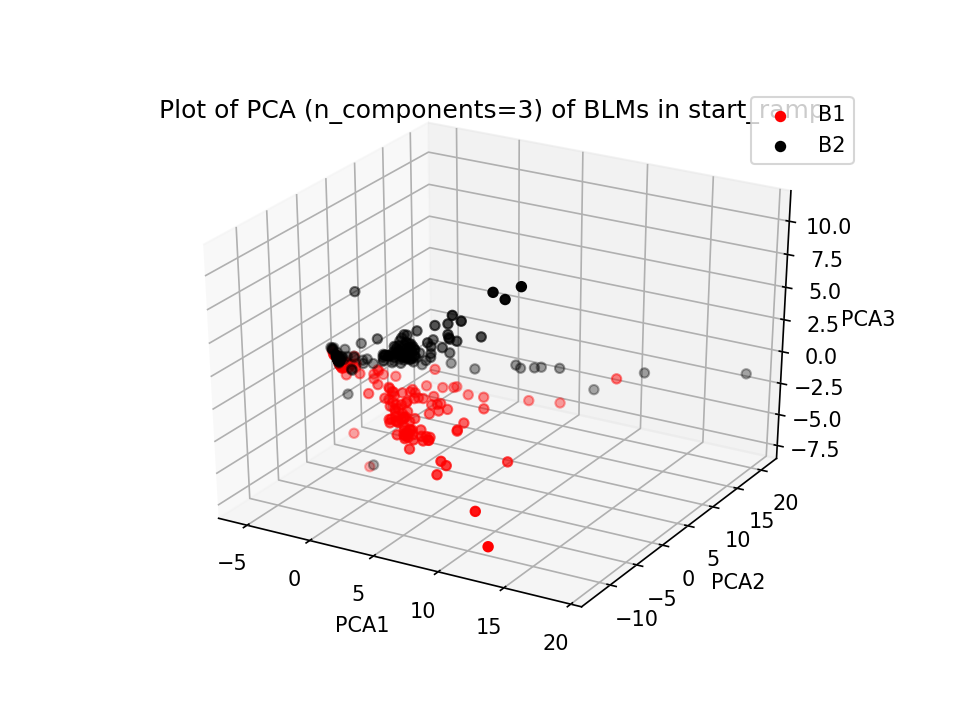

In [8]:
scatterPlotLosses(startRampLossesPCA, "Plot of PCA (n_components=3) of BLMs in start_ramp")

<IPython.core.display.Javascript object>


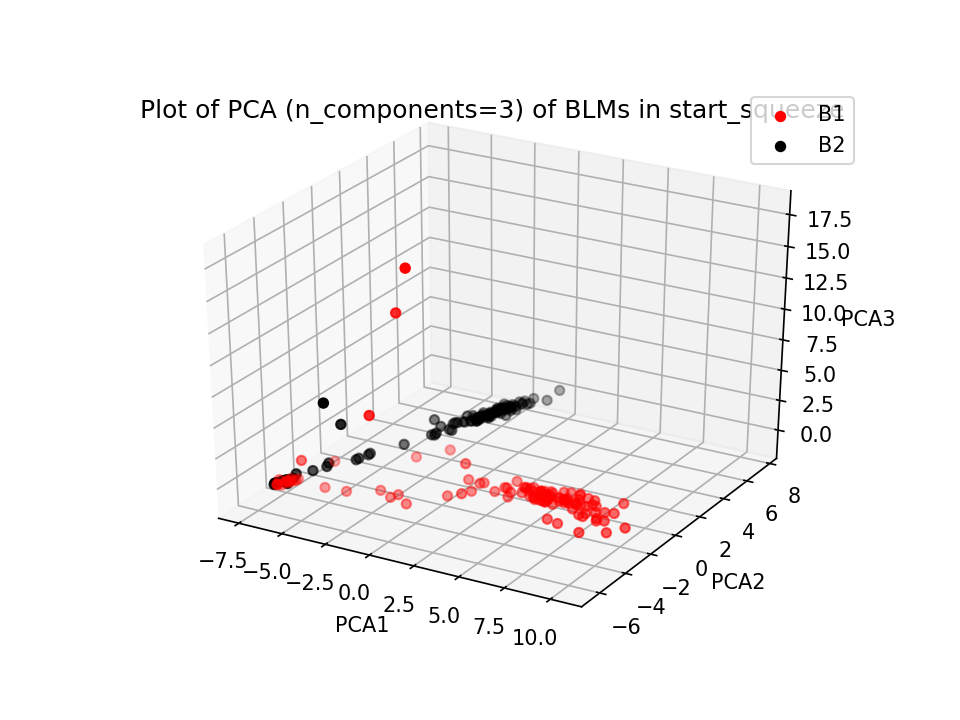

In [9]:
scatterPlotLosses(startSqueezeLossesPCA, "Plot of PCA (n_components=3) of BLMs in start_squeeze")

<IPython.core.display.Javascript object>


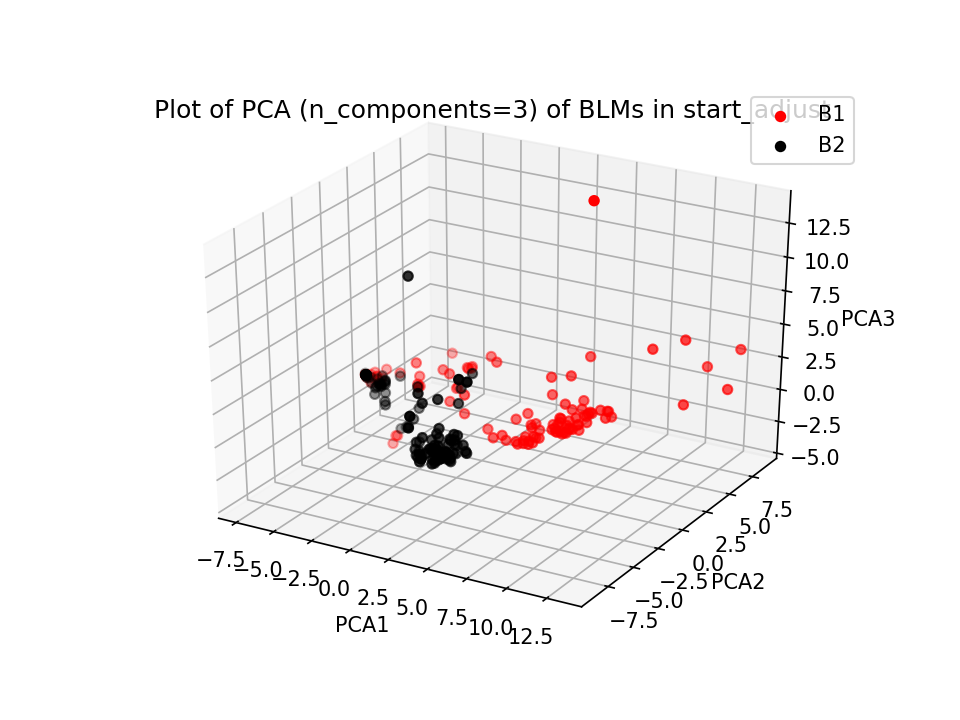

In [10]:
scatterPlotLosses(startAdjustLossesPCA, "Plot of PCA (n_components=3) of BLMs in start_adjust")

<IPython.core.display.Javascript object>


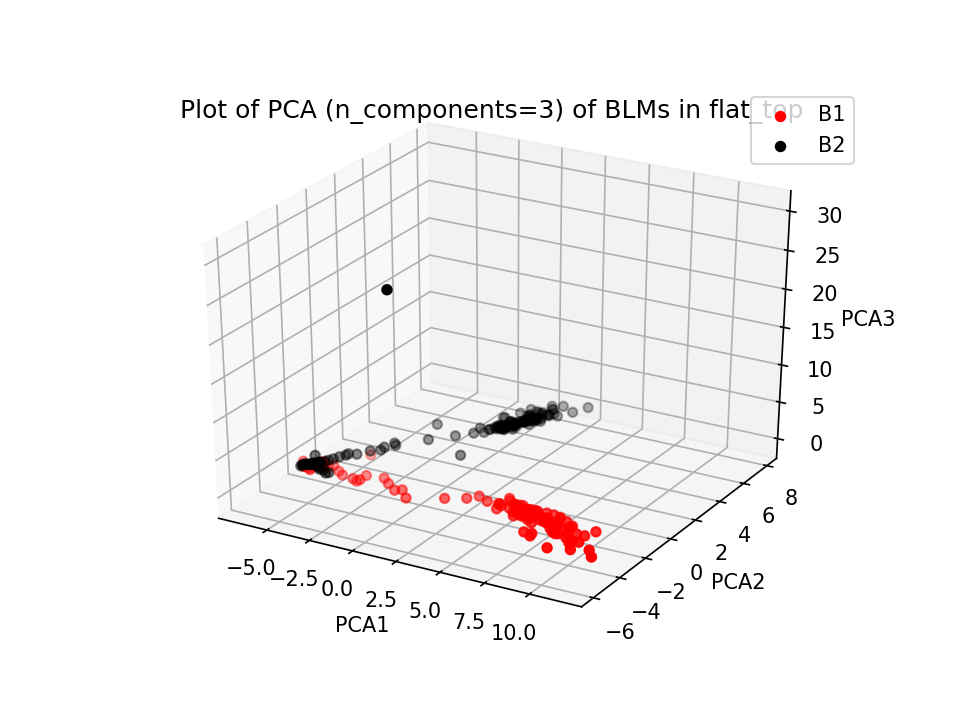

In [11]:
scatterPlotLosses(flatTopLossesPCA, "Plot of PCA (n_components=3) of BLMs in flat_top")

## KMeans clustering

### Helper function

In [26]:
def compareKMeansWithGroundTruth(labels, losses):
    for clusterNo in range(0, 2):  # loop through cluster 0, 1
        b1Count = 0
        b2Count = 0
        indicesOfLossesInCluster = np.where(kmeans.labels_ == clusterNo)[0]
        lossesInClusterCount = len(indicesOfLossesInCluster)
        
        for key in losses.index.values[indicesOfLossesInCluster]:
            if key[0] == 'B1':
                b1Count = b1Count + 1
            elif key[0] == 'B2':
                b2Count = b2Count + 1
            else:
                print("Key error - neither B1 nor B2 in key {}".format(key))
                
        assert b1Count + b2Count == lossesInClusterCount
        
        if b1Count <= b2Count:
            print(f'Cluster {clusterNo} is {(b2Count / lossesInClusterCount):.2%} B2 losses')
        elif b1Count > b2Count:
            print(f'Cluster {clusterNo} is {(b1Count / lossesInClusterCount):.2%} B1 losses')

### Analysis

#### On full feature-space

In [27]:
kmeans = KMeans(n_clusters = 2)

kmeans.fit(startRampLosses)
# print("start_ramp Cluster memberships:\n{}".format(kmeans.labels_))
print("start_ramp\n");
compareKMeansWithGroundTruth(kmeans.labels_, startRampLosses)

kmeans.fit(startAdjustLosses)
# print("start_adjust Cluster memberships:\n{}".format(kmeans.labels_))
print("\nstart_adjust\n");
compareKMeansWithGroundTruth(kmeans.labels_, startAdjustLosses)

kmeans.fit(startSqueezeLosses)
# print("start_squeeze Cluster memberships:\n{}".format(kmeans.labels_))
print("\nstart_squeeze\n");
compareKMeansWithGroundTruth(kmeans.labels_, startSqueezeLosses)

kmeans.fit(flatTopLosses)
# print("flat_top Cluster memberships:\n{}".format(kmeans.labels_))
print("\nflat_top\n");
compareKMeansWithGroundTruth(kmeans.labels_, flatTopLosses)

start_ramp

Cluster 0 is 50.78% B2 losses
Cluster  0  is  50.78125 % 	B2 losses
Cluster 1 is 50.57% B1 losses
Cluster  1  is  50.57471264367817 % 	B1 losses

start_adjust

Cluster 0 is 50.70% B1 losses
Cluster  0  is  50.70422535211267 % 	B1 losses
Cluster 1 is 51.02% B2 losses
Cluster  1  is  51.02040816326531 % 	B2 losses

start_squeeze

Cluster 0 is 79.31% B2 losses
Cluster  0  is  79.3103448275862 % 	B2 losses
Cluster 1 is 100.00% B1 losses
Cluster  1  is  100.0 % 	B1 losses

flat_top

Cluster 0 is 71.09% B2 losses
Cluster  0  is  71.09004739336493 % 	B2 losses
Cluster 1 is 98.90% B1 losses
Cluster  1  is  98.9010989010989 % 	B1 losses


#### On PCA features

In [53]:
kmeans.fit(startRampLossesPCA)
# find whether majority of points in cluster 1 are B1 or B2. do the same for cluster 2.
print("start_ramp\n");
compareKMeansWithGroundTruth(kmeans.labels_, startRampLossesPCA)


# kmeans.fit(startAdjustLosses)
# # print("start_adjust Cluster memberships:\n{}".format(kmeans.labels_))
# print("\nstart_adjust\n");
# compareKMeansWithGroundTruth(kmeans.labels_, startAdjustLosses)

# kmeans.fit(startSqueezeLosses)
# # print("start_squeeze Cluster memberships:\n{}".format(kmeans.labels_))
# print("\nstart_squeeze\n");
# compareKMeansWithGroundTruth(kmeans.labels_, startSqueezeLosses)

# kmeans.fit(flatTopLosses)
# # print("flat_top Cluster memberships:\n{}".format(kmeans.labels_))
# print("\nflat_top\n");
# compareKMeansWithGroundTruth(kmeans.labels_, flatTopLosses)

start_ramp

Cluster 0 has majority B1 losses. But 85 / 172 are B2 losses.
Cluster 1 has majority B2 losses. But 64 / 130 are B1 losses.


**Plotting**

<IPython.core.display.Javascript object>


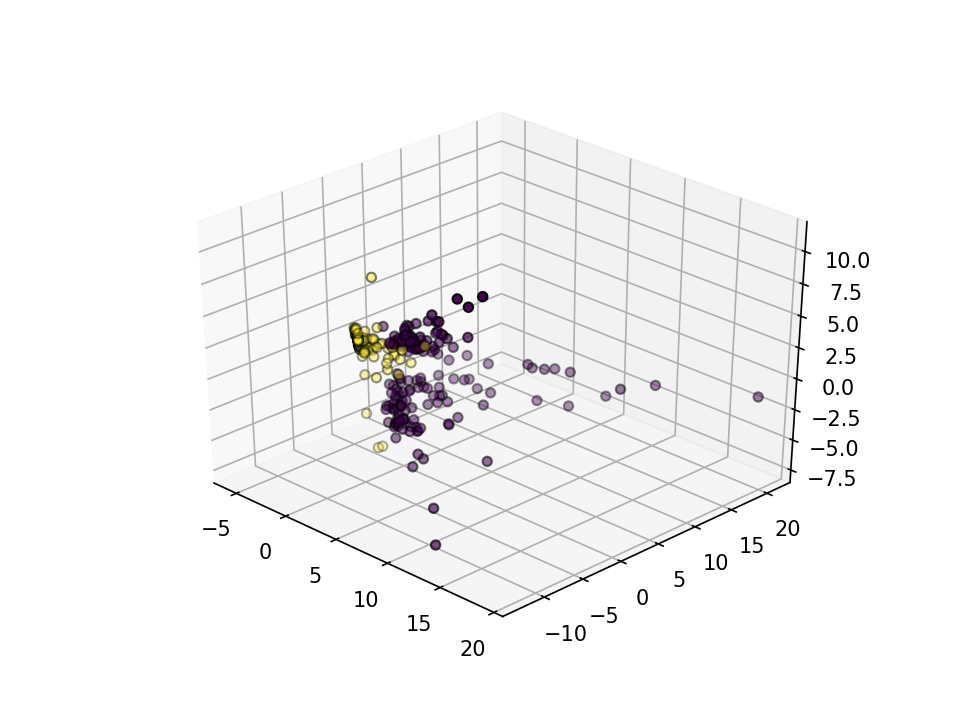

In [79]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# xs = mergedLosses.loc['B1'][mergedLosses.columns[0]]
# ys = mergedLosses.loc['B1'][mergedLosses.columns[1]]
# zs = mergedLosses.loc['B1'][mergedLosses.columns[2]]
# ax.scatter(, ys, zs, c='red', label='B1')

# xs = mergedLosses.loc['B2'][mergedLosses.columns[0]]
# ys = mergedLosses.loc['B2'][mergedLosses.columns[1]]
# zs = mergedLosses.loc['B2'][mergedLosses.columns[2]]
# ax.scatter(xs, ys, zs, c='black', label='B2')

# ax.set_xlabel(mergedLosses.columns[0])
# ax.set_ylabel(mergedLosses.columns[1])
# ax.set_zlabel(mergedLosses.columns[2])
# plt.legend()
# plt.title(title)
# plt.show()

# startRampLosses.loc['B1'][startRampLosses.columns[0]]
# startRampLossesPCA['PCA1']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(startRampLossesPCA['PCA1'], startRampLossesPCA['PCA2'], startRampLossesPCA['PCA3'],
           c=kmeans.labels_, edgecolor='k')
# ax.set_xlabel(startRampLossesPCA.columns[0])
# ax.set_ylabel(startRampLossesPCA.columns[1])
# ax.set_zlabel(startRampLossesPCA.columns[2])
# plt.legend()
# plt.title(title)
plt.show()

## DBSCAN



In [7]:
from sklearn.cluster import DBSCAN
# eps - "The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not
#        a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose 
#        appropriately for your data set and distance function."
# min_samples - "The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
#                This includes the point itself."
# 


dbs = clustering = DBSCAN(eps=0.9, min_samples=5)
dbs.fit(startRampLosses)
print("start_ramp Cluster memberships:\n{}".format(dbs.labels_)) # Outliers are assigned to the -1 cluster

start_ramp Cluster memberships:
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0
  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0 -1  0  0 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0
  0 -1  0  0 -1 -1 -1  0  0  0  0  0  0  0  1  1  1  1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  2  2  2  2  2  2  2  2  2 -1  2 -1  2  2  2  2  2  2 -1
  2  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2  2  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  2 -1 -1  2  2  2 -1  2  2 -1 -1 -1  2  2  2  2  2  2  2 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


<IPython.core.display.Javascript object>


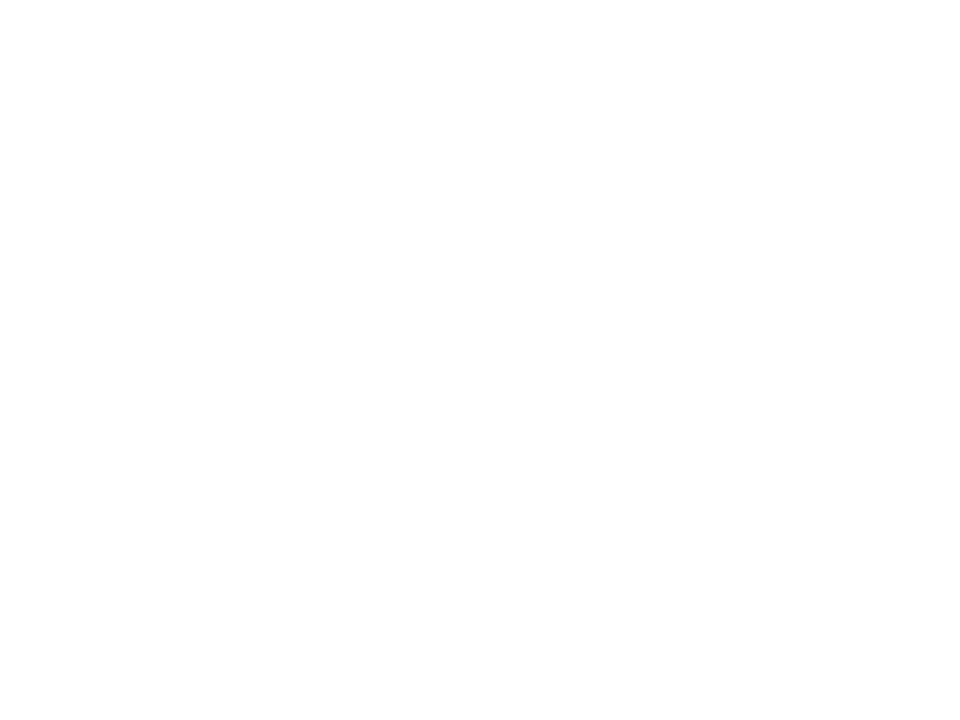

In [8]:
import matplotlib.ticker as plticker

# Data
df = pd.DataFrame({
    'B1': startRampLosses.loc['B1']['TCP.C6x7'],
    'B2': startRampLosses.loc['B2']['TCP.C6x7']
})
 
# multiple line plot
fig, ax = plt.subplots()
ax.plot('B1', data=df, marker='x', color='red')
ax.plot('B2', data=df, marker='x', color='black')
ax.set(xlabel='Fill', ylabel='Loss', title='Plot of the loss registered in TCP.C6x7 against the fill number')
ax.legend()
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=15.0))  # set freqeuency of x-axis labels (fill numbers)

<IPython.core.display.Javascript object>


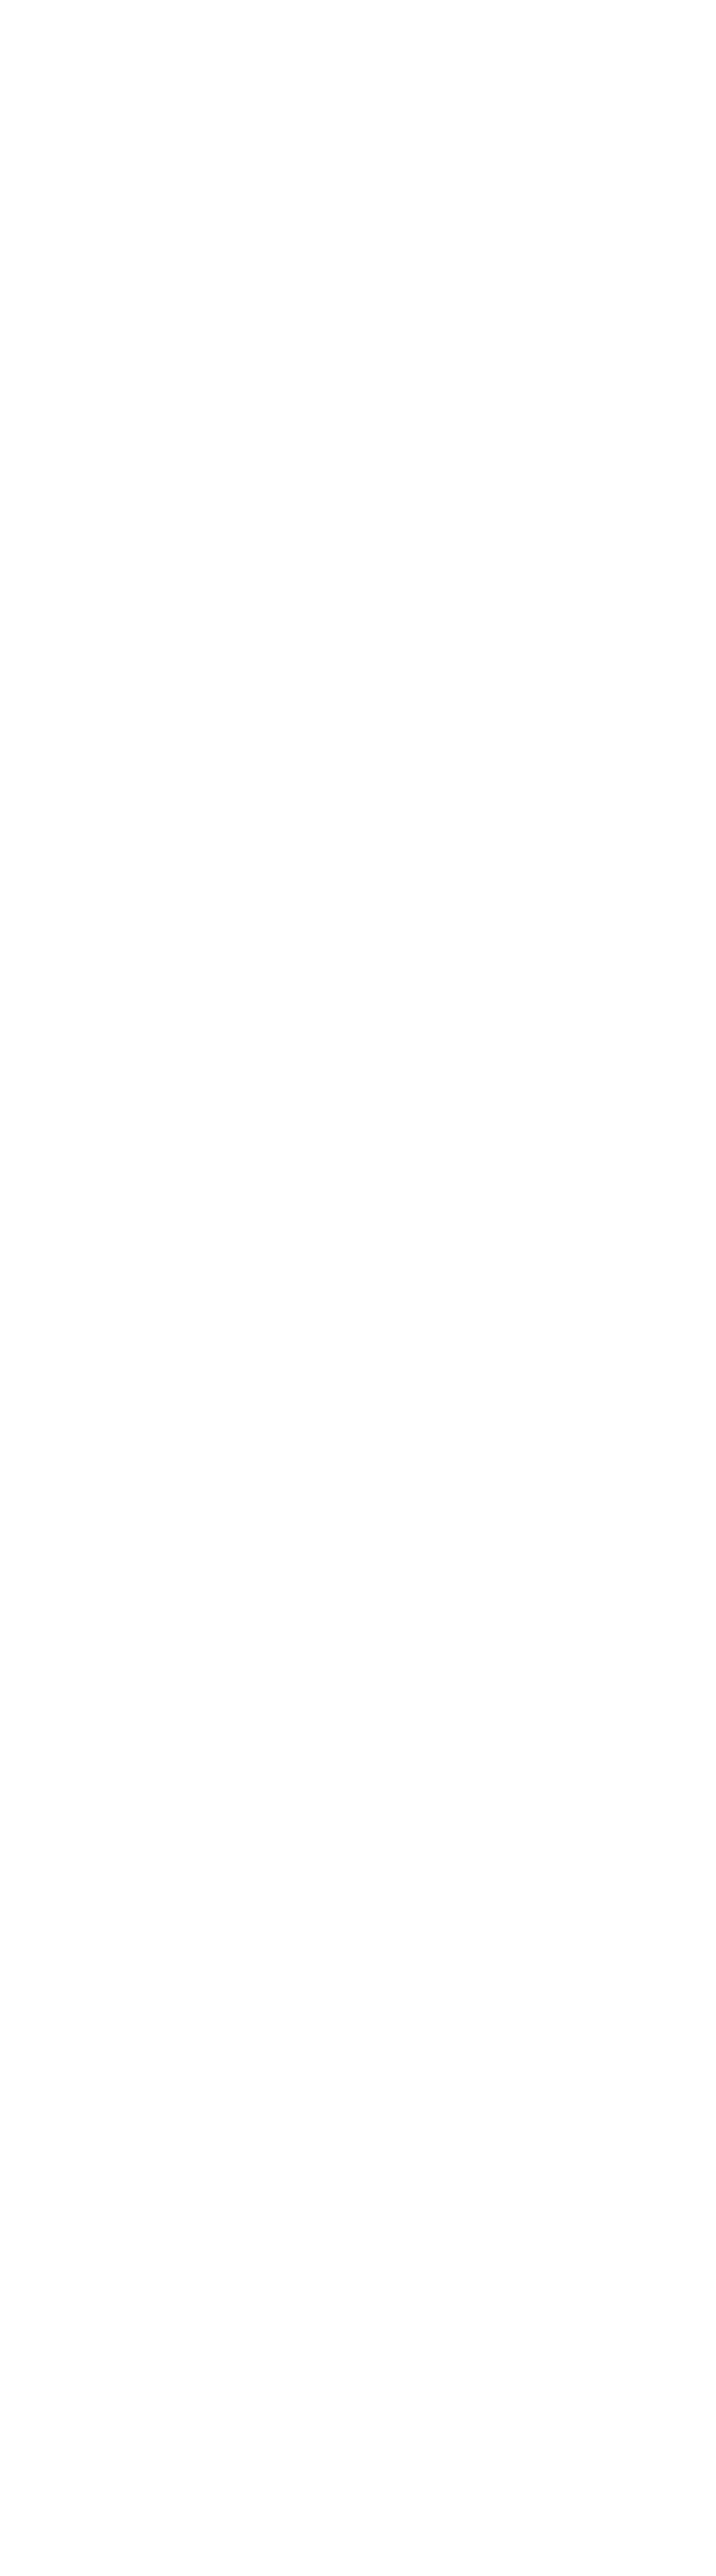

C:\Users\mvell\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  


In [9]:
plt.figure(figsize=(10, 36))
ncols = 3;
nrows = math.ceil(startRampLosses.shape[1] / ncols)
i = 1;
for column in startRampLosses:
    # Data
    df = pd.DataFrame({
        'B1': startRampLosses.loc['B1'][column],
        'B2': startRampLosses.loc['B2'][column]
    })
 
    plt.subplot(nrows, ncols, i)
    plt.yscale('log')
    plt.plot('B1', data=df, marker='x', color='red')
    plt.plot('B2', data=df, marker='x', color='black')
    plt.title(column)

    
    i = i + 1
    

plt.tight_layout()

## Euclidean distance

In [10]:
#To get Euclidean distance between the BLM vectors for beam 1 and beam 2
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean

startRampDistance = pd.Series(
    cdist(startRampLosses.loc['B1'].values, startRampLosses.loc['B2'].values, metric='euclidean').diagonal(),
    index=startRampLosses.loc['B1'].index)  # in order to preserve the fill numbers for x-axis of the euclidean distance plot
startAdjustDistance = pd.Series(
    cdist(startAdjustLosses.loc['B1'].values, startAdjustLosses.loc['B2'].values, metric='euclidean').diagonal(),
    index=startAdjustLosses.loc['B1'].index)
startSqueezeDistance = pd.Series(
    cdist(startSqueezeLosses.loc['B1'].values, startSqueezeLosses.loc['B2'].values, metric='euclidean').diagonal(),
    index=startSqueezeLosses.loc['B1'].index)
flatTopDistance = pd.Series(
    cdist(flatTopLosses.loc['B1'].values, flatTopLosses.loc['B2'].values, metric='euclidean').diagonal(),
    index=flatTopLosses.loc['B1'].index)

#getting diagonal to get the euclidean distance of pairs of vectors we care about (i.e. corresponding rows)
#eg. euclidean distance between row 0 of B1 values, row 0 of B2 values; euclidean distance between row 1 of B1 values,
#row 1 of B2 values, and so on.

#to confirm values are correct:
# print(distance)
# print(euclidean(mergedPhaseLosses.loc['B1'].iloc[0], mergedPhaseLosses.loc['B2'].iloc[0]))
# print(euclidean(mergedPhaseLosses.loc['B1'].iloc[1], mergedPhaseLosses.loc['B2'].iloc[1]))
# print(euclidean(mergedPhaseLosses.loc['B1'].iloc[2], mergedPhaseLosses.loc['B2'].iloc[2]))


<IPython.core.display.Javascript object>


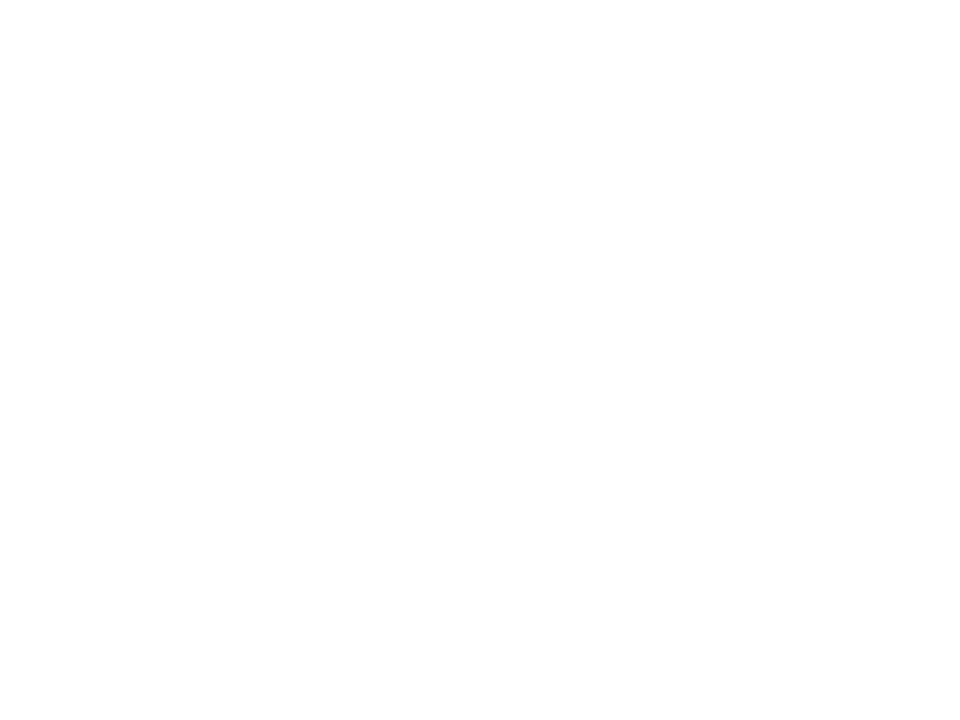

Text(0, 0.5, 'Euclidean distance')

In [11]:
# To plot Euclidean between the vectors (TCP, TCSG, ...) for beam 1 and beam 2
# Data
df = pd.DataFrame({
    'start_ramp': startRampDistance,
    'start_adjust': startAdjustDistance,
    'start_squeeze': startSqueezeDistance,
    'flat_top': flatTopDistance
})
 
# multiple line plot
plt.figure()
plt.yscale('log')
plt.plot('start_ramp', data=df, marker='x', color='black')
plt.plot('start_adjust', data=df, marker='x', color='red')
plt.plot('start_squeeze', data=df, marker='x', color='yellow')
plt.plot('flat_top', data=df, marker='x', color='blue')
plt.legend()
plt.title('Plot of Euclidean distance between the BLM vectors of the two beams')
plt.xlabel('Fill')
plt.ylabel('Euclidean distance')